In [1]:
#Libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import random
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

In [2]:
from FC_NN_Architecture import *
# Dataset Loader File
from DF_DataLoader import initDataset, toDataset

In [3]:
# Data visualization of NN
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange

In [4]:
import scipy.io
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Crunch through parameter estimates

## 1. Load model

Note that `PE_path` has the lambda oracle estimates.

In [7]:
axes_all = []
dS_Dict = {"NDND" : None, "NDReg": None}
means = None
stdevs = None
snr = 50.0
k = 0
dp = "Testing"
# estim_path = f"RegCurves_GCV/REG__GCV_SNR_{snr}_{dp}Data.feather"
# PE_path = f"SyntheticGCVDataset/LambdaGCVs_{dp}_SNR_{snr}_SyntheticRicianNoise.feather"
estim_path = f"RegularizationTrajectories/REG__DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_{dp}Data.feather"
PE_path = f"ParameterEstimationData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_{dp}Data.feather"

df = pd.read_feather(PE_path)

means, stdevs = None, None
if dp !="Training":
    means = torch.tensor([0])
    stdevs = torch.tensor([1])

GCV = False
raw_dataset = toDataset(dp, estim_path, PE_path, means = means, stdevs = stdevs, GCV=GCV)


NDND_NAME = f"3P_RicianNoise__ILR__NDND__SNR_{snr}"
# NDReg_NAME = f"3P_NDReg__GCV__NDReg__SNR_{snr}"
NDReg_NAME = f"3P_NDReg__ILR__NDReg__SNR_{snr}"


NDND_path = f"ParameterEstimationNetworks/{NDND_NAME}L2Loss_TE32_B64_lr1e4.pth"
checkpoint_NDND = torch.load(NDND_path, map_location=device)

# NDReg_path = f"GCV Parameter estimation models/{NDReg_NAME}L2Loss_TE32_B64_lr1e4.pth"
NDReg_path = f"ParameterEstimationNetworks/{NDReg_NAME}L2Loss_TE32_B64_lr1e4.pth"

checkpoint_NDReg = torch.load(NDReg_path, map_location=device)

# device = torch.device("cuda:0") #WAS CUDA:7

input_size = 64
H1,H2,H3,H4 = 32,256,256,32
output_size = 3

model_NDND = LambdaTraining_FC_NN(input_size, H1, H2, H3, H4, output_size)
model_NDND.load_state_dict(checkpoint_NDND['model_state_dict'])
model_NDND.to(device)
model_NDND.eval()


model_NDReg = LambdaTraining_FC_NN(input_size, H1, H2, H3, H4, output_size)
model_NDReg.load_state_dict(checkpoint_NDReg['model_state_dict'])
model_NDReg.to(device)

model_NDReg.eval()

Building Testing Dataset...
Recon Signal:  (3200000, 32)
torch.Size([3200000, 32])
torch.Size([3200000, 32])
IDX BASED?  True
BEGIN ND_REG!!!
DATASET:  torch.Size([3200000, 2, 32])


LambdaTraining_FC_NN(
  (inputMap): Linear(in_features=64, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=32, bias=True)
  (outputMap): Linear(in_features=32, out_features=3, bias=True)
)

In [22]:
snr = 100.0
PE_path = f"ParameterEstimationData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_{dp}Data.feather"
df = pd.read_feather(PE_path)
print(np.sqrt(np.mean( (df['T22_t']-df['T22_est'])**2 )))

7.530425557849415


## 2. Crank through data

In [8]:
dataload = DataLoader(raw_dataset, batch_size=1500)
idx, (noisy_decay, targets) = next(enumerate(dataload))

In [9]:
dataload = DataLoader(raw_dataset, batch_size=1500)
rL = 0.0
with torch.no_grad():
    training_preds_NDND = torch.empty((0, 3)).to(device=device)
    training_preds_NDReg = torch.empty((0, 3)).to(device=device)
    curr_pos_reg = 0
    end_pos_reg = 0
    for idx, (noisy_decay, targets) in enumerate(tqdm(dataload, unit = "batch")):
        batch_size = noisy_decay.size(0)
        end_pos_reg += batch_size
        assert(torch.all(noisy_decay == (dataload.dataset.training_tensor_proc)[curr_pos_reg : end_pos_reg]))
        noisy_decay, targets = noisy_decay.to(device), targets.to(device)
        
        pred_NDND = model_NDND(noisy_decay[:,0,:].repeat(1,2))
        pred_NDReg = model_NDReg(noisy_decay.flatten(1))

        # training_preds_NDND[curr_pos_reg : end_pos_reg] = pred_NDND
        # training_preds_NDReg[curr_pos_reg : end_pos_reg] = pred_NDReg

        training_preds_NDND = torch.cat((training_preds_NDND, pred_NDND))
        training_preds_NDReg = torch.cat((training_preds_NDReg, pred_NDReg))
        curr_pos_reg += batch_size

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2134/2134 [00:35<00:00, 60.79batch/s]


In [10]:
res = dataload.dataset.target_tensor_proc
NDReg_preds = training_preds_NDReg.detach().cpu()
NDND_preds = training_preds_NDND.detach().cpu()

## 3a. Analyze the data for sliced images

In [11]:
# set up data 
# res = dataload.dataset.target_tensor_proc
T21s = torch.unique(res[:,0])
T22s = torch.unique(res[:,1])
c1s = torch.unique(res[:,2])
# c1_val = c1s[4]
# NDReg_preds = training_preds_NDReg.detach().cpu()
# NDND_preds = training_preds_NDND.detach().cpu()

error_tensors = [] 
bias = []
variances = [] 
for k in tqdm(range(c1s.shape[0])):
    c1_val = c1s[k]
    error_tensor = np.zeros((T21s.shape[0], T22s.shape[0]))
    bias_tensor = np.zeros((T21s.shape[0], T22s.shape[0]))
    var_tensor = np.zeros((T21s.shape[0], T22s.shape[0]))
    # get error tensor 
    for i in range(T21s.shape[0]):
        for j in range(T22s.shape[0]):
            T21_val = T21s[i]
            T22_val = T22s[j]
            comp_inds = np.linalg.norm(res.numpy() - np.array([T21_val, T22_val, c1_val]), axis = 1) == 0.0
            NDReg_PE = torch.sqrt(torch.mean((NDReg_preds[comp_inds,2].flatten() - res[comp_inds,2].flatten())**2))
            NDND_PE = torch.sqrt(torch.mean((NDND_preds[comp_inds,2].flatten() - res[comp_inds,2].flatten())**2))
            bias_NDReg_PE = (torch.mean(NDReg_preds[comp_inds,2].flatten()) - c1_val)**2
            bias_NDND_PE = (torch.mean(NDND_preds[comp_inds,2].flatten()) - c1_val)**2
            var_NDReg_PE = torch.var(NDReg_preds[comp_inds,2].flatten())
            var_NDND_PE = torch.var(NDND_preds[comp_inds,2].flatten())
            error_tensor[i,j] = NDReg_PE - NDND_PE
            bias_tensor[i,j] = bias_NDReg_PE - bias_NDND_PE
            var_tensor[i,j] = var_NDReg_PE - var_NDND_PE
    error_tensors.append(error_tensor)
    bias.append(bias_tensor)
    variances.append(var_tensor)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:41<00:00, 26.10s/it]


In [12]:
import matplotlib
import matplotlib.pyplot as plt

### Plot stuff

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.56it/s]


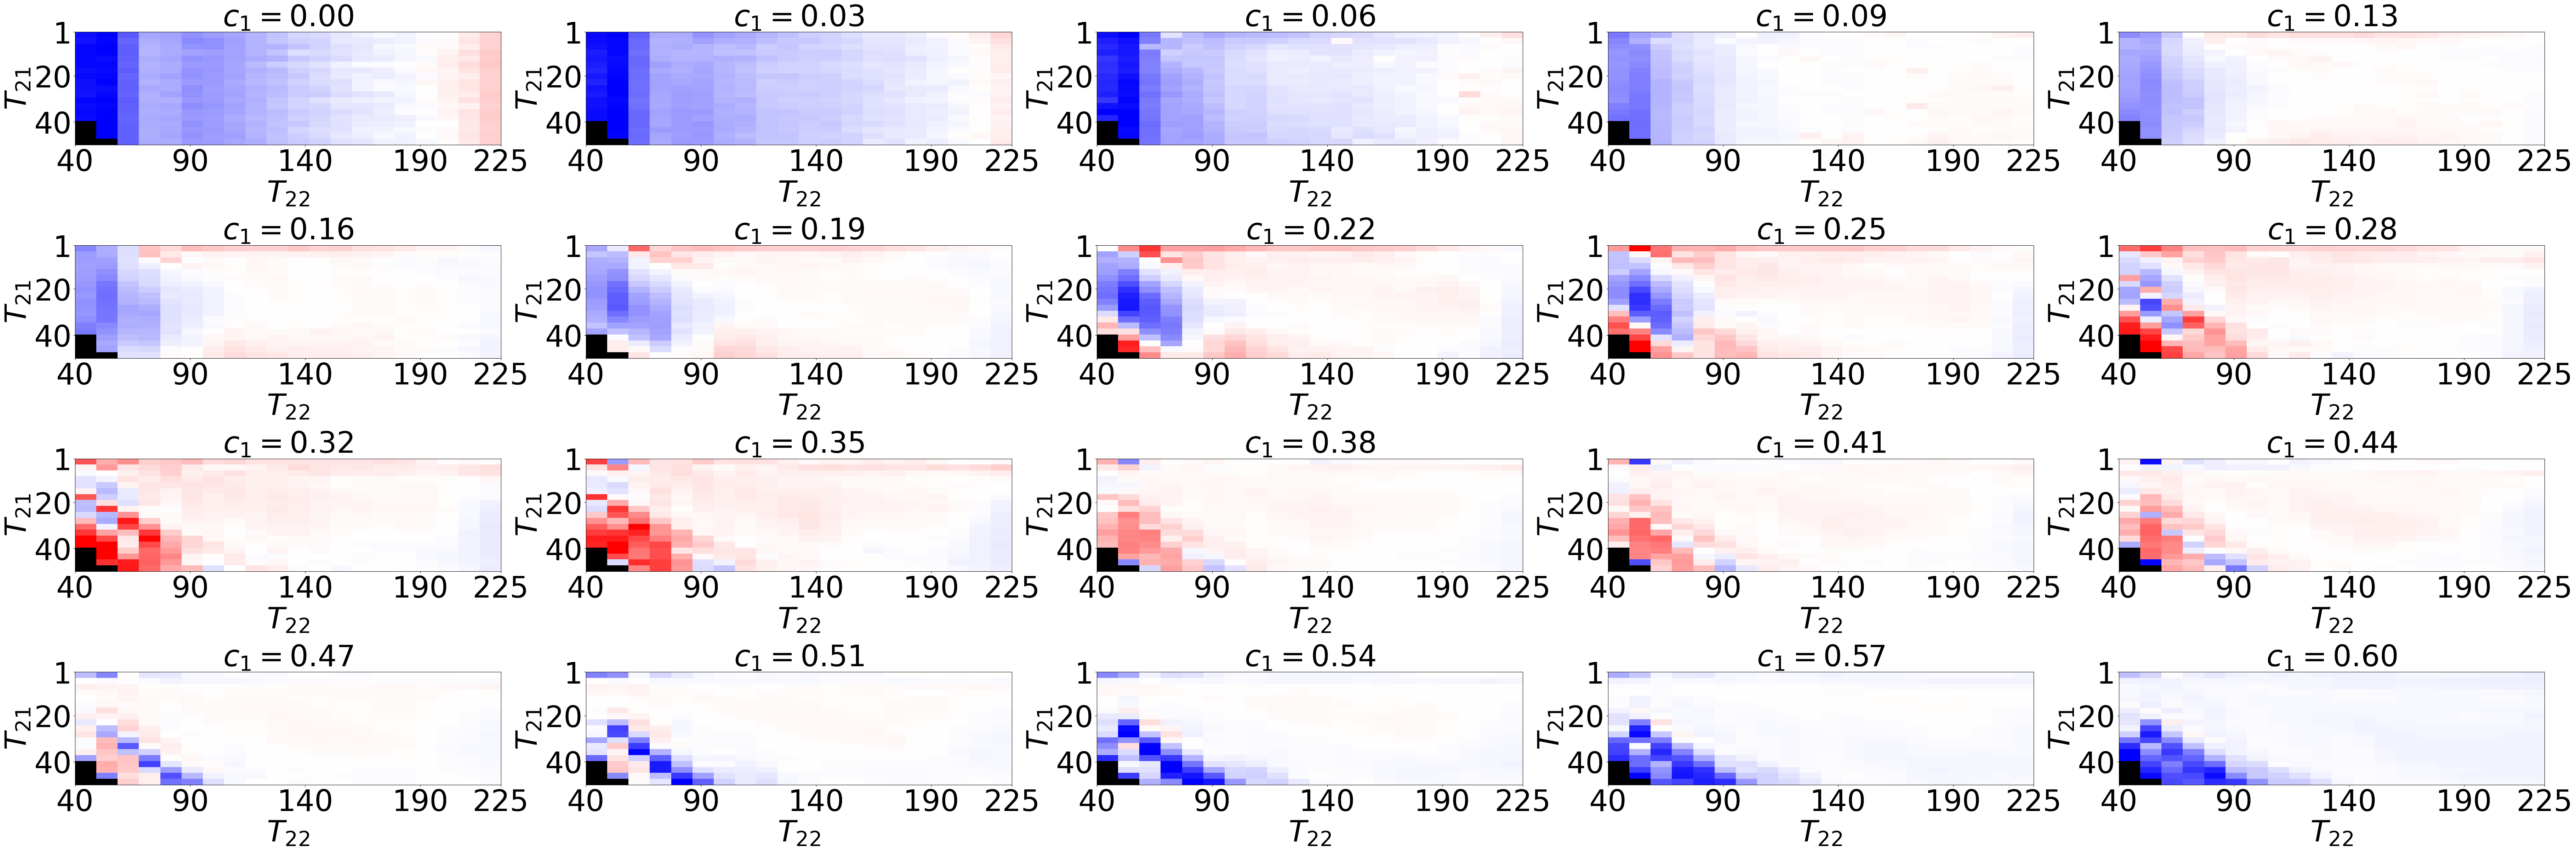

In [14]:
fig = plt.figure(figsize=(90,30))
for i in tqdm(range(len(error_tensors))):
    c1_val = c1s[i]
    error_tensor = error_tensors[i]
    ax = fig.add_subplot(4,5,i+1)
    T22_select = np.where(~np.isnan(error_tensor[0,:]))[0]
    T21_select = np.where(~np.isnan(error_tensor[:,6]))[0]
    selected_T21s = T21s[T21_select]
    selected_T22s = T22s[T22_select]
    bias_tensor = error_tensors[i]
    # selected_error_tensor = error_tensor[T21_select,:][:,T22_select]
    selected_error_tensor = bias_tensor[T21_select,:][:,T22_select]
    renormalization_factor = max(np.abs(min(selected_error_tensor[~np.isnan(selected_error_tensor)])), np.abs(max(selected_error_tensor[~np.isnan(selected_error_tensor)])))
    plot_tensor = selected_error_tensor/renormalization_factor
    limsize = np.nanpercentile(np.abs(plot_tensor.flatten()), 99)
    cmap = matplotlib.cm.get_cmap('bwr').copy()
    cmap.set_bad(color='black')
    cmap.set_over(color='red')
    cmap.set_under(color='blue')
    img = ax.imshow(plot_tensor[1:], cmap=cmap, vmin=-limsize, vmax=limsize, \
            extent=[min(selected_T22s), max(selected_T22s), max(selected_T21s), min(selected_T21s)])
    ax.set_title(f'$c_1 = ${c1_val:.2f}', fontsize=60)
    ax.set_xlabel("$T_{22}$", fontsize = 60)
    ax.set_ylabel("$T_{21}$", fontsize = 60)
    ax.tick_params(labelsize=60)
    ax.set_yticks([1, 20, 40])
    ax.set_xticks([40, 90, 140, 190, 225])
# fig.savefig(f'SNR_100_RMSEComparison_NDNDvNDRegGCV.png')
fig.show()

